In [28]:
import random
import pandas as pd
import seaborn as sns

from base import *
from distribution_functions import *

In [2]:
class Server:
    def __init__(self) -> None:
        self.isCurrentlyUtilized: bool = False
        self.totalUtilizationTime: float = 0

In [3]:
class Customer:
    def __init__(self) -> None:
        self.serviceTime: float
        self.departure: float
        self.arrival: float

    @property
    def totalTime(self) -> float:
        return self.departure - self.arrival

    @property
    def waitingTime(self) -> float:
        return self.totalTime - self.serviceTime

In [4]:
from base import Dict, SimEvent


class SingleQueueMultiServerController(SimController):
    def __init__(
        self,
        initialEvent: SimEvent,
        stop: float,
        numberOfServers: int,
        serverUtilizationStrategy: str,
    ) -> None:
        assert numberOfServers > 0, "Non-positive number of servers"

        assert serverUtilizationStrategy in [
            "random",
            "firstAvailable",
        ], "Invalid server selection strategy"

        super().__init__(initialEvent, stop)

        self._history: List[Customer] = []
        self._queue: List[Customer] = []

        self._servers: Dict[int, Server] = {
            i: Server() for i in range(1, numberOfServers + 1)
        }

        self._serverUtilizationStrategy = serverUtilizationStrategy

    @property
    def history(self) -> List[Customer]:
        return self._history

    @property
    def queue(self) -> List[Customer]:
        return self._queue

    @property
    def servers(self) -> Dict[int, Server]:
        return self._servers

    @property
    def serverUtilizationStrategy(self) -> str:
        return self._serverUtilizationStrategy

    def getAvailableServerId(self) -> int:
        serverId: int = -1

        servers = list(self.servers.items())

        if self.serverUtilizationStrategy == "random":
            random.shuffle(servers)

        for id, server in servers:
            if not server.isCurrentlyUtilized:
                serverId = id

        return serverId

    def simulate(self) -> Dict[str, float]:
        super().simulate()

        aup = sum(
            server.totalUtilizationTime / self.clock for server in self.servers.values()
        ) / len(self.servers)

        awtp = sum(
            customer.waitingTime / customer.totalTime for customer in self.history
        ) / len(self.history)

        return {"AUP": aup, "AWTP": awtp}

In [5]:
class AbleBakerController(SingleQueueMultiServerController):
    def __init__(
        self,
        initialEvent: SimEvent,
        stop: float,
        serverUtilizationStrategy: str,
    ) -> None:
        super().__init__(
            initialEvent,
            stop,
            numberOfServers=2,
            serverUtilizationStrategy=serverUtilizationStrategy,
        )

    def simulate(self) -> Dict[str, float]:
        super().simulate()

        positiveWaitingTimes = list(
            filter(
                lambda waitingTime: waitingTime > 0,
                map(lambda customer: customer.waitingTime, self.history),
            )
        )

        return {
            "AWT": sum(positiveWaitingTimes) / len(positiveWaitingTimes),
            "WP": len(positiveWaitingTimes) / len(self.history),
        } | {
            f"UP_{id}": server.totalUtilizationTime / self.clock
            for id, server in self.servers.items()
        }

In [6]:
DEPARTURE_EVENT_INTERVAL = None


class DepartureEvent(SimEvent[AbleBakerController]):
    def __init__(self, customer: Customer, serverId: int) -> None:
        super().__init__(DEPARTURE_EVENT_INTERVAL())

        assert serverId >= 1

        self._customer = customer
        self._serverId = serverId

    @property
    def customer(self) -> Customer:
        return self._customer

    @property
    def serverId(self) -> int:
        return self._serverId

    def dispatch(self) -> None:
        self.customer.serviceTime = self.interval
        self.customer.departure = self.due

        self.controller.history.append(self.customer)

        self.controller.servers[self.serverId].totalUtilizationTime += self.interval

        if self.controller.queue:
            customer = self.controller.queue.pop(0)

            self.controller.enqueueEvent(DepartureEvent(customer, self.serverId))
        else:
            self.controller.servers[self.serverId].isCurrentlyUtilized = False

In [7]:
ARRIVAL_EVENT_INTERVAL = None


class ArrivalEvent(SimEvent[AbleBakerController]):
    def __init__(self, initial: bool = False) -> None:
        super().__init__(0 if initial else ARRIVAL_EVENT_INTERVAL())

        self._customer = Customer()

    @property
    def customer(self) -> Customer:
        return self._customer

    def dispatch(self) -> None:
        self.customer.arrival = self.due

        self.controller.enqueueEvent(ArrivalEvent())

        serverId = self.controller.getAvailableServerId()

        if serverId == -1:
            self.controller.queue.append(self.customer)
        else:
            self.controller.servers[serverId].isCurrentlyUtilized = True
            self.controller.enqueueEvent(DepartureEvent(self.customer, serverId))

In [8]:
ARRIVAL_EVENT_INTERVAL = lambda: uniform(3, 6)
DEPARTURE_EVENT_INTERVAL = lambda: uniform(9, 12)


all_results = []

for i in range(100):
    results = AbleBakerController(
        initialEvent=ArrivalEvent(initial=True),
        stop=9 * 60,
        serverUtilizationStrategy="firstAvailable",
    ).simulate()

    all_results.append(results)

pd.DataFrame(all_results).mean(axis=0)

AWT     38.799180
WP       0.977139
UP_1     0.978797
UP_2     0.986265
dtype: float64

In [9]:
ARRIVAL_EVENT_INTERVAL = lambda: uniform(3, 6)
DEPARTURE_EVENT_INTERVAL = lambda: uniform(9, 12)

all_results = []

for i in range(100):
    results = AbleBakerController(
        initialEvent=ArrivalEvent(initial=True),
        stop=9 * 60,
        serverUtilizationStrategy="random",
    ).simulate()

    all_results.append(results)

pd.DataFrame(all_results).mean(axis=0)

AWT     38.425538
WP       0.977325
UP_1     0.982004
UP_2     0.983235
dtype: float64

In [16]:
ARRIVAL_EVENT_INTERVAL = lambda: uniform(0, 4)
DEPARTURE_EVENT_INTERVAL = lambda: uniform(6, 10)

all_results = {}

for numberOfServers in range(1, 11):
    iter_results = []

    for i in range(100):
        results = SingleQueueMultiServerController(
            initialEvent=ArrivalEvent(initial=True),
            stop=8 * 60,
            numberOfServers=numberOfServers,
            serverUtilizationStrategy="random",
        ).simulate()

        iter_results.append(results)

    all_results[numberOfServers] = pd.DataFrame(iter_results).mean(axis=0)

df = pd.DataFrame(all_results).T

df["Score"] = 2 * df["AUP"] * (1 - df["AWTP"]) / (df["AUP"] + (1 - df["AWTP"]))

df

,AUP,AWTP,Score
1,0.989139,0.904112,0.174828
2,0.987227,0.874708,0.222363
3,0.985082,0.803341,0.327864
4,0.957079,0.397630,0.739384
5,0.787263,0.056384,0.858378
6,0.657598,0.013264,0.789226
7,0.562584,0.002417,0.719441
8,0.492508,0.000477,0.659870
9,0.435927,0.000137,0.607146
10,0.392823,0.000037,0.564062


<Axes: >

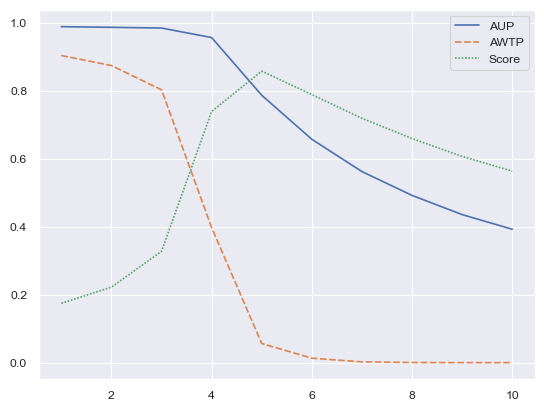

In [38]:
sns.set_theme("paper")
sns.lineplot(df)